# Producing single peaked, skewed idealised profiles
## Background
It is standard practice in flood modelling to use design rainfall profiles generated by FEH/ReFH2. We are interested in examining whether distributing rainfall over time in multiple peaks, rather than just one, will result in a different flooding outcome. 

## Constructing synthetic multiple peaked events
The FEH single-peak profiles are always produced with a single peak which can be characterised by:
1) The total corresponding rainfall volume $V$.  
2) The duration $d$ (start to end).  
3) The shape of the peak, defined here: https://refhdocs.hydrosolutions.co.uk/Design-DDF-Rainfall-Hyetographs/Design-Storm-Profiles/  

TBC....

In [1]:
from datetime import datetime, timedelta
import pandas as pd
from dateutil.relativedelta import relativedelta
import sys
import matplotlib.patches as mpatches
from matplotlib import dates as mdates
import re
sys.path.insert(1, '../')
from Functions import *

In [2]:
catchment_rainfall = {'LinDyke':59.29,
                     'WykeBeck':59.25}

In [3]:
catchment_name = 'LinDyke'

### Define the different methods 

In [4]:
methods =['6h_sp_fl_0.1', '6h_sp_fl_0.2', '6h_sp_fl_0.3', '6h_sp_fl_0.4','6h_sp_c_0.5',
          '6h_sp_bl_0.6','6h_sp_bl_0.7','6h_sp_bl_0.8','6h_sp_bl_0.9']
colors = ['darkblue']*2 + ['deepskyblue']*2 + ['grey']+ ['indianred']*2+['darkred']*2

duration = '6h'
N_subpeaks = 1
default_peak_shape='refh2-summer'
total_mm_accum= catchment_rainfall[catchment_name]
total_duration_minutes = (int(duration[0]) * 60) +1
subpeak_duration_minutes=total_duration_minutes/6

# Create datetimes to go with values
start = datetime(2022,8,1,0,0,0)
end = start + relativedelta(hours=int(duration[0]))
end = end - timedelta(minutes=1) 

if total_duration_minutes == (int(duration[0]) * 60) +1:
    seconds = (end - start).total_seconds() + 61
else:    
    seconds = (end - start).total_seconds() + 60 
step = timedelta(minutes=1)
datetimes = []
for i in range(0, int(seconds), int(step.total_seconds())):
    datetimes.append(start + timedelta(seconds=i))       

### Create dataframe for one method containing the accumulation and rate at each minute of time

In [5]:
# For each method produce a dataframe containing precipitation values for each minute and save these to file
for method in methods:

    # Get profile peak before frac parameter
    if len(re.findall("\d+\.\d+", method))>0:
        peak_before_frac = float(re.findall("\d+\.\d+", method)[0])
    else:
        peak_before_frac = 0.5

    # Find accumulation and rate
    accum, rate = calc_rainfall_curves(method,total_mm_accum,total_duration_minutes,N_subpeaks,
                                       subpeak_duration_minutes,peak_before_frac)
    # Create as dataframe
    accum_df = pd.DataFrame({'Dates': datetimes,  'Rate (mm/hr)': rate, 'Rate (mm/min)': rate/60})
    # Keep only columns needed for feeding to ReFH2
    accum_df = accum_df[['Dates','Rate (mm/min)']]

    # Write to csv
    accum_df.to_csv("{}/{}r_100yrRP/PreLossRemoval/{}.csv".format(catchment_name, duration, method),header = False, index = False)

    # Print 
    # print(method + ". Max rainfall rate: " + str(round(accum_df['Rate (mm/min)'].max(),2)) + "mm/min")
    # print("Total rainfall in event: " + str(round(accum_df['Rate (mm/min)'].sum(),2)) + "mm")

### Create a dataframe sepecifying the volume of rainfall within each 5th of the event
Also the max value in each 5th (to check whether the fifth where the peak in intensity occurs, is the same as where the greatest volume is)

In [6]:
# breaks = range(0,360,72)
# rainfall_volume_df = pd.DataFrame()
# rainfall_peak_df = pd.DataFrame()

# for num, method in enumerate(methods):
#     # Read in post loss removal rainfall data
#     post_loss_removal = pd.read_csv('../IdealisedProfiles/' + "6hr_100yrRP/PostLossRemoval/{}_urban.csv".format(method))
#     # Format time column
#     post_loss_removal = clean_dfs(post_loss_removal)
#     # Create a list containing the total rainfall rate in each chunk of time 
#     rainfall_volume_ls =[]
#     rainfall_peak_ls = []
#     for i in breaks:
#         rainfall_volume_ls.append(post_loss_removal.iloc[i:(i+72)]['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].sum())
#         rainfall_peak_ls.append(post_loss_removal.iloc[i:(i+72)]['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].max())
#     rainfall_volume_df[method] = rainfall_volume_ls
#     rainfall_peak_df[method] = rainfall_peak_ls
    
# rainfall_volume_df.loc['Total']= rainfall_volume_df.sum()

## Plot pre loss removal profiles

In [7]:
def plot_profile_shape_prelossremoval(ax, number, method, total_duration_minutes, folder_fp, color):
    pre_loss_removal = pd.read_csv(folder_fp + "6hr_100yrRP/PreLossRemoval/{}.csv".format(method), names =['Time', 'Rain'])
    pre_loss_removal['Time'] =  np.array(range(total_duration_minutes))   
    
    ax.plot(pre_loss_removal['Time'], pre_loss_removal['Rain'], color = color, linestyle = 'dotted')
    ax.set_title('I{}'.format(number+1), fontsize = 18)
    
def plot_profile_shape_postlossremoval(ax, number, method,total_duration_minutes, folder_fp, color):
    post_loss_removal = pd.read_csv(folder_fp + "6hr_100yrRP/PostLossRemoval/{}_urban.csv".format(method))
    # Filter to only include those within the first 6 hours
    post_loss_removal = post_loss_removal[:total_duration_minutes]
    # Convert date to datetime
    post_loss_removal['Time'] =  np.array(range(total_duration_minutes))     
    # PLot
    ax.plot(post_loss_removal['Time'], post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'], 
            color = color)
    ax.set_title('I{}'.format(number+1), fontsize = 18)


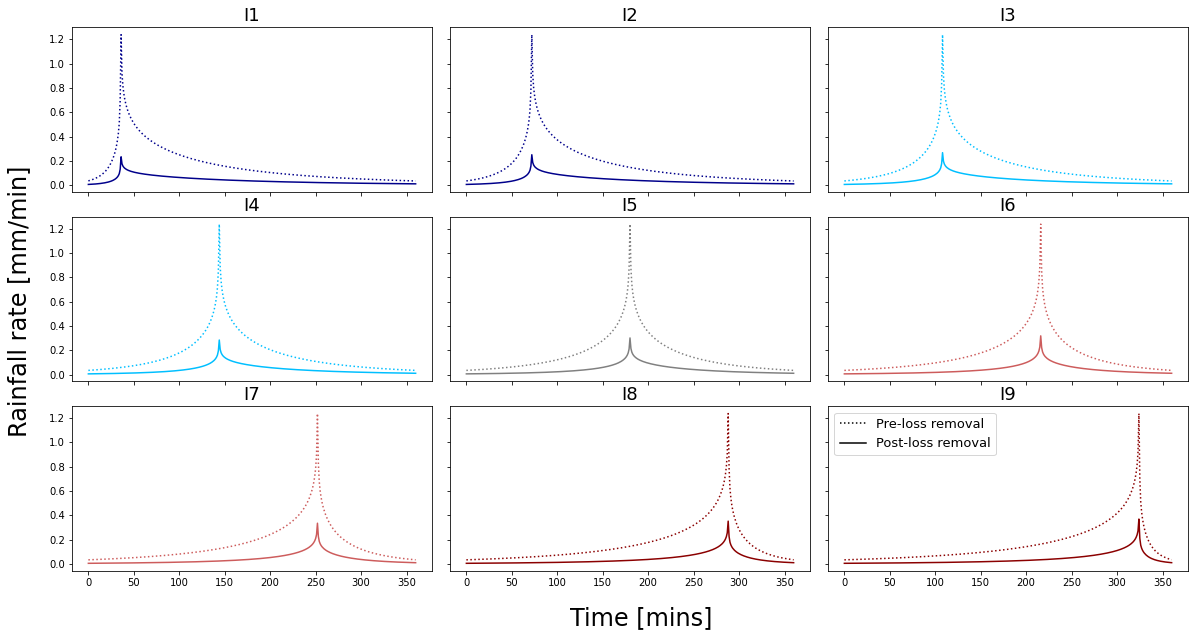

In [12]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize = (20,10), sharex = True, sharey = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.05, hspace=0.15)

for number, ax in enumerate(axs.reshape(-1)): 
    if number <9:
        plot_profile_shape_prelossremoval(ax, number, methods[number], total_duration_minutes, "../IdealisedProfiles/{}/".format(catchment_name), color = colors[number])
        plot_profile_shape_postlossremoval(ax, number, methods[number], total_duration_minutes, "../IdealisedProfiles/{}/".format(catchment_name), color = colors[number])
        
    #ax.plot(range(0,361), sp_profile['100 year design rainfall - FEH 2013 model'][:361], color = 'black', linewidth=1.5, linestyle = 'dotted') 
    #ax.plot(range(0,361), sp_profile['Total net rain mm (100 year) - urbanised model'][:361], linewidth = 3, color='black') 
        
fig.text(0.08, 0.5, "Rainfall rate [mm/min]", va='center', rotation='vertical', fontsize =24)
fig.text(0.52, 0.05, 'Time [mins]', ha='center', fontsize =24);

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='black', linestyle='dotted'),
                Line2D([0], [0], color='black')]
plt.legend(custom_lines, ['Pre-loss removal', 'Post-loss removal'], fontsize=13)

fig.savefig("../../PlotsForPaper/Figs/Profiles/Idealised.png", bbox_inches='tight')

## Plot post loss removal profiles 

In [13]:
model_directory = "../IdealisedProfiles/{}/".format(catchment_name)

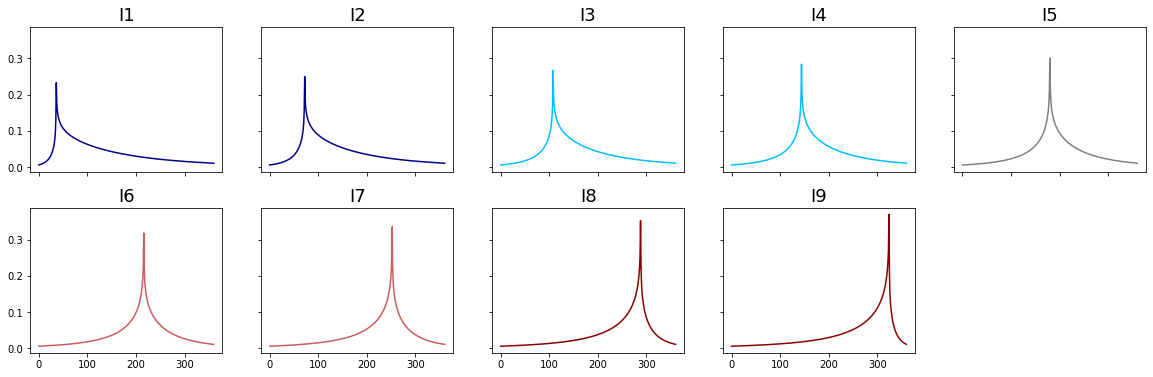

In [15]:
fig, axs = plt.subplots(nrows=2, ncols=5, figsize = (20,6), sharex = True, sharey = True)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.25)

for number, ax in enumerate(axs.reshape(-1)): 
    if number <9:
        plot_profile_shape_postlossremoval(ax, number, methods[number], total_duration_minutes,model_directory, color = colors[number])
    elif number == 9:
        ax.axis('off')                       

## Plotting

### Plot the loss removal

In [ ]:
# # Create figure
# fig, axes = plt.subplots(3, len(methods), figsize=(18,4), sharex =True, sharey = 'row')

# for axes_number, method in enumerate(methods):
#     pre_loss_removal = pd.read_csv('../IdealisedProfiles/' + "6hr_100yrRP/PreLossRemoval/{}.csv".format(method), names = ['Time', 'Rainfall'])
#     post_loss_removal = pd.read_csv('../IdealisedProfiles/' + "6hr_100yrRP/PostLossRemoval/{}_urban.csv".format(method))
    
#     post_loss_removal['losses'] =(post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model']/post_loss_removal['Observed rainfall - 01/08/2022 00:00'])   

#     # Plot pre loss removal rainfall
#     axes[0, axes_number].plot(np.array(range(total_duration_minutes))+0.5, post_loss_removal['Urban net rain mm (Observed rainfall - 01/08/2022) - urbanised model'], color = colors[axes_number])
#     # plot the amount of losses remove
#     axes[1, axes_number].plot(np.array(range(total_duration_minutes))+0.5, post_loss_removal['losses'], color = colors[axes_number])
#     # plot the post loss removal rate
#     axes[2, axes_number].plot(np.array(range(total_duration_minutes))+0.5, post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'], color = colors[axes_number])
    
# fig.text(0.5, -0.05, 'Minute', ha='center', size =16);
# fig.text(0.08, 0.7, 'Losses removed (mm)', va='center', rotation='vertical', size = 10);
# # fig.text(0.08, 0.7, 'Cumulative\n rainfall (mm)', va='center', rotation='vertical', size = 10);
# fig.text(0.08, 0.3, 'Rainfall rate\n (mm/min)', va='center', rotation='vertical', size = 10);    

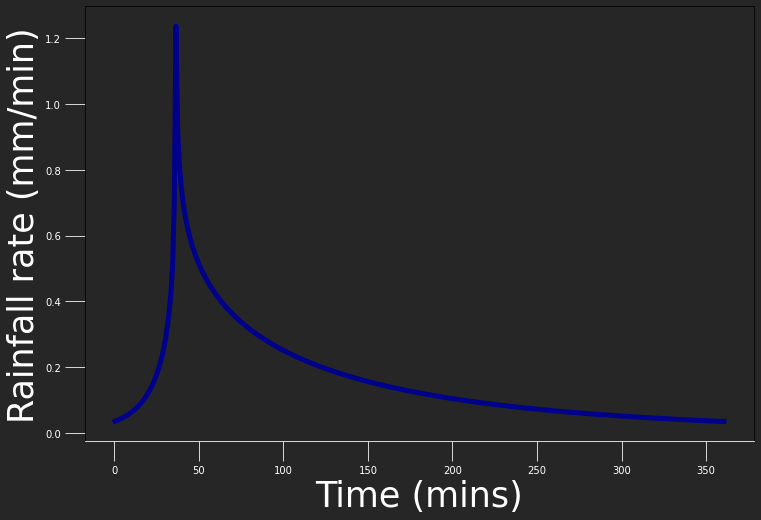

In [16]:
fig, ax = plt.subplots(figsize=(12,8))
colors = ['darkblue']*2 + ['paleturquoise']*2 + ['grey']+ ['indianred']*2+['darkred']*2

max_rainfall_rate_after_loss_removal = []
for axes_number, method in enumerate(methods):
    if method in ['6h_sp_fl_0.1']:
        # Read in data
        pre_loss_removal = pd.read_csv(model_directory + "6hr_100yrRP/PreLossRemoval/{}.csv".format(method), names = ['Time', 'Rainfall'])
        post_loss_removal = pd.read_csv(model_directory + "6hr_100yrRP/PostLossRemoval/{}_urban.csv".format(method))

        # Calculate the cumulative rainfall 
        post_loss_removal['cumulative_rainfall_this_min'] = post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].cumsum()

        # Plot pre loss removal rainfall rate
        ax.plot(np.array(range(total_duration_minutes))+0.5,pre_loss_removal['Rainfall'], 
                color=colors[axes_number], linewidth = 5)   
        ax.set_xlabel('Time (mins)', color='white', fontsize=35)
        ax.set_ylabel('Rainfall rate (mm/min)', color='white', fontsize=35)
        #axes[0].set_title('Rainfall rate [mm/min] pre loss removal')


        # CHECK WHETHER TOTAL RAINFALL VOLUME IS CONSERVED
        #print("Max rainfall (after loss removal): ", round(post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].max(),5))
        #print("Max rainfall (before loss removal): ", round(pre_loss_removal['Rainfall'].max(),5))
        max_rainfall_rate_after_loss_removal.append(round(post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].max(),5))
        #print("Total event rainfall (after loss removal): ", round(post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].sum(),3))
        #print("Total event rainfall (before loss removal): ", round(pre_loss_removal['Rainfall'].sum(),2))

plt.gca().set_facecolor('#262626')  # Set the background color to black
plt.gcf().set_facecolor('#262626')
colors_leg = [ 'darkblue', 'paleturquoise','grey', 'indianred', 'darkred']
# texts = ['Very front loaded','Front loaded','Centred', 'Black loaded', 'Very back loaded'] 
texts = ['F2','F1','C', 'B1', 'B2'] 
patches = [ mpatches.Patch(color=colors_leg[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
# plt.legend(handles=patches, bbox_to_anchor=(1.37, 0.5), loc='center', ncol=1, prop={'size': 15});
ax.tick_params(axis='both', colors='white', size =20)
ax.spines['bottom'].set_color('white')
# fig.savefig(model_directory + "6hr_100yrRP/PostLossRemoval/Profile_plots.PNG");     

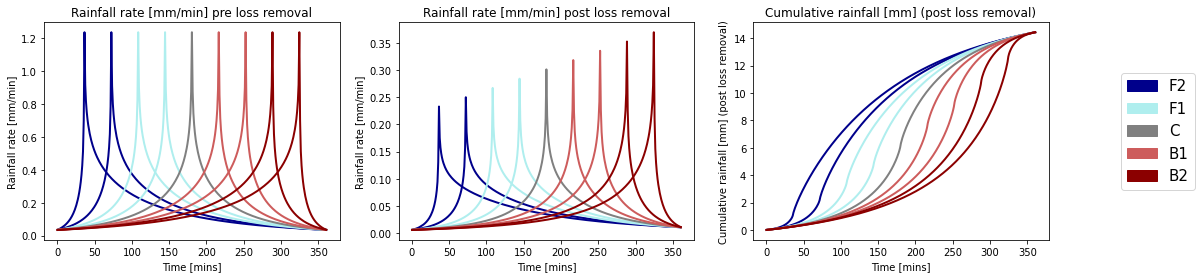

In [17]:
fig, axes = plt.subplots(1, 3,figsize=(18,4), sharex =True, sharey = False)
colors = ['darkblue']*2 + ['paleturquoise']*2 + ['grey']+ ['indianred']*2+['darkred']*2

max_rainfall_rate_after_loss_removal = []

for axes_number, method in enumerate(methods):
    # Read in data
    pre_loss_removal = pd.read_csv(model_directory + "6hr_100yrRP/PreLossRemoval/{}.csv".format(method), names = ['Time', 'Rainfall'])
    post_loss_removal = pd.read_csv(model_directory + "6hr_100yrRP/PostLossRemoval/{}_urban.csv".format(method))
    
    # Calculate the cumulative rainfall 
    post_loss_removal['cumulative_rainfall_this_min'] = post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].cumsum()
    
    # Plot pre loss removal rainfall rate
    axes[0].plot(np.array(range(total_duration_minutes))+0.5,pre_loss_removal['Rainfall'], color=colors[axes_number], linewidth = 2)   
    axes[0].set_xlabel('Time [mins]')
    axes[0].set_ylabel('Rainfall rate [mm/min]')
    axes[0].set_title('Rainfall rate [mm/min] pre loss removal')
    
    # Plot post loss removal rainfall rate
    axes[1].plot(np.array(range(total_duration_minutes))+0.5,post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'], color=colors[axes_number], linewidth = 2)   
    axes[1].set_xlabel('Time [mins]')
    axes[1].set_ylabel('Rainfall rate [mm/min]')
    axes[1].set_title('Rainfall rate [mm/min] post loss removal')
    
    # Plot cumulative rainfall rate
    axes[2].plot(np.array(range(total_duration_minutes))+0.5,post_loss_removal['cumulative_rainfall_this_min'], color=colors[axes_number], linewidth = 2)   
    axes[2].set_xlabel('Time [mins]')
    axes[2].set_ylabel('Cumulative rainfall [mm] (post loss removal)')
    axes[2].set_title('Cumulative rainfall [mm] (post loss removal)')
    
    # CHECK WHETHER TOTAL RAINFALL VOLUME IS CONSERVED
    #print("Max rainfall (after loss removal): ", round(post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].max(),5))
    #print("Max rainfall (before loss removal): ", round(pre_loss_removal['Rainfall'].max(),5))
    max_rainfall_rate_after_loss_removal.append(round(post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].max(),5))
    #print("Total event rainfall (after loss removal): ", round(post_loss_removal['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'].sum(),3))
    #print("Total event rainfall (before loss removal): ", round(pre_loss_removal['Rainfall'].sum(),2))
    
colors_leg = [ 'darkblue', 'paleturquoise','grey', 'indianred', 'darkred']
# texts = ['Very front loaded','Front loaded','Centred', 'Black loaded', 'Very back loaded'] 
texts = ['F2','F1','C', 'B1', 'B2'] 
patches = [ mpatches.Patch(color=colors_leg[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.37, 0.5), loc='center', ncol=1, prop={'size': 15});
fig.savefig(model_directory + "6hr_100yrRP/PostLossRemoval/Profile_plots.PNG");    

### Compare wetter and drier antecedent conditions

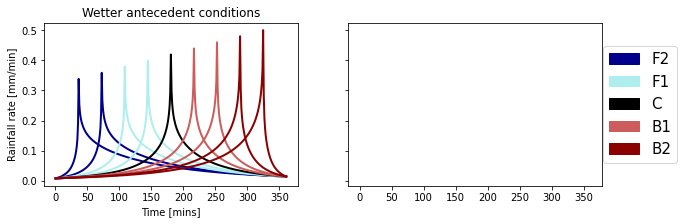

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10,3), sharex =True, sharey = True)
colors = ['darkblue']*2 + ['paleturquoise']*2 + ['black']+ ['indianred']*2+['darkred']*2

for axes_number, method in enumerate(methods):
    # Read in data
    post_loss_removal1 = pd.read_csv(model_directory+ "6hr_100yrRP/PostLossRemoval/{}_urban.csv".format(method))
#     post_loss_removal2 = pd.read_csv(model_directory+ "6hr_100yrRP/PostLossRemoval_jja_mean_15days/{}_urban.csv".format(method))
    
    # Plot post loss removal rainfall rate
    axes[0].plot(np.array(range(total_duration_minutes))+0.5,post_loss_removal1['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'], color=colors[axes_number], linewidth = 2)   
    axes[0].set_xlabel('Time [mins]')
    axes[0].set_ylabel('Rainfall rate [mm/min]')
    axes[0].set_title('Wetter antecedent conditions')
    
#     axes[1].plot(np.array(range(total_duration_minutes))+0.5,post_loss_removal2['Total net rain mm (Observed rainfall - 01/08/2022) - urbanised model'], color=colors[axes_number], linewidth = 2)   
#     axes[1].set_xlabel('Time [mins]')
#     axes[1].set_ylabel('Rainfall rate [mm/min]')
#     axes[1].set_title('Drier antecedent conditions')
    
colors_leg = ['darkblue', 'paleturquoise', 'black', 'indianred', 'darkred']
texts = ['F2','F1','C', 'B1', 'B2'] 
patches = [ mpatches.Patch(color=colors_leg[i], label="{:s}".format(texts[i]) ) for i in range(len(texts)) ]
plt.legend(handles=patches, bbox_to_anchor=(1.15, 0.5), loc='center', ncol=1, prop={'size': 15});
fig.savefig(model_directory + "6hr_100yrRP/PostLossRemoval/Profile_plots.PNG");    

### Plot just pre-loss removal, with FEH profile comparison

In [18]:
feh_profile = pd.read_csv("../ReFH2_singlepeak/6hr_100yrRP_6.01h_1mintimestep.csv")

fig, ax = plt.subplots(figsize=(5,4))
colors = ['darkblue']*2 + ['paleturquoise']*2 + ['grey']+ ['indianred']*2+['darkred']*2

max_rainfall_rate_after_loss_removal = []

for axes_number, method in enumerate(methods):
    # Read in data
    pre_loss_removal = pd.read_csv(model_directory + "6hr_100yrRP/PreLossRemoval/{}.csv".format(method), names = ['Time', 'Rainfall'])
    ax.plot(np.array(range(total_duration_minutes))+0.5,pre_loss_removal['Rainfall'], color=colors[axes_number], linewidth = 2)   
    ax.set_xlabel('Time [mins]')
    ax.set_ylabel('Rainfall rate [mm/min]')

# loop through tickers and axes
ax.plot(range(0,361), feh_profile['100 year design rainfall - FEH 2013 model'][:361], color = 'black', linewidth=2.5, linestyle = 'solid') 
# fig.savefig("test.png")


FileNotFoundError: [Errno 2] No such file or directory: '../ReFH2_singlepeak/6hr_100yrRP_6.01h_1mintimestep.csv'

### With drier antecedent conditions, there are more losses in general
Want to know if there are also proportionally more losses removed from front loaded profiles?
The losses removed in total volume are the same across all profiles (but just the peak is reduced more in the FL profiles).
So, can check whether the reducton in peak intensities is greater with drier conditions?



In [39]:
# print(max_rainfall_rate_after_loss_removal[0]/ max_rainfall_rate_after_loss_removal[-1])
# print(max_rainfall_rate_after_loss_removal_jja_mean_15days[0]/ max_rainfall_rate_after_loss_removal_jja_mean_15days[-1])

In [ ]:
for i in range(0,len(max_rainfall_rate_after_loss_removal_jja_mean_15days)):
    print(round(max_rainfall_rate_after_loss_removal_jja_mean_15days[i]/1.2373*100,1))

In [ ]:
for i in range(0,len(max_rainfall_rate_after_loss_removal)):
    print(round(max_rainfall_rate_after_loss_removal[i]/1.2373*100,1))

In [ ]:
previous = max_rainfall_rate_after_loss_removal_jja_mean_15days[0]
current = max_rainfall_rate_after_loss_removal_jja_mean_15days[-1]
change_percent = ((float(current)-previous)/previous)*100
change_percent

In [ ]:
previous = max_rainfall_rate_after_loss_removal[0]
current = max_rainfall_rate_after_loss_removal[-1]
change_percent = ((float(current)-previous)/previous)*100
change_percent